## Analyzing Social Media Data In Python

collecting data through the Twitter API

In [2]:
import scipy
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import networkx as nx
import nxviz as nz

### Processing twitter text

In [70]:
ds_tweets = pd.read_csv("hashtags.csv")

In [8]:
print(ds_tweets['text'].values[0:5])

[ 'RT @pythonbot_: Learning Penetration Testing With Python  https://t.co/seRRrwhvwn #python #programming #pythonbot_'
 'RT @I_m_ranjeet: Is Language Agnosticism the Future of #Software #Development? Know Here ?  https://t.co/xMWh4zGclc #Java #PHP #Javascript…'
 "#python goes to #school for #beginner #scientist and #engineer. It's so easy to find solution for #equation in form… https://t.co/JM8jGllwxk"
 'Easy way to set Oracle Active Dataguard\n☞ https://t.co/sPjMJE2Pfl\n#data #science #python #tableau #sql #R\nHyWotyN_M https://t.co/S2RvAxcyRH'
 'Python 3 for Beginners\n☞ https://t.co/va5XaJXVOy\n#python #programming #development #course\nSJ4KjeVOM https://t.co/r94xugsd4A']


## Finding Keywords

In [9]:
# Find mentions of #python in 'text'
python = ds_tweets['text'].str.contains('#python', case = False)

# Print proportion of tweets mentioning #python
print("Proportion of #python tweets:", np.sum(python) / ds_tweets.shape[0])

Proportion of #python tweets: 0.427715996578


### Looking for text in all the wrong places

Recall that relevant text may not only be in the main text field of the tweet. It may also be in the extended_tweet, the retweeted_status, or the quoted_status. We need to check all of these fields to make sure we've accounted for all the of the relevant text. We'll do this often so we're going to create a function which does this.

The first two lines check if the main text field or the extended_tweet contain the text. You will need to check the rest.

In [10]:
def check_word_in_tweet(word, data):
    """Checks if a word is in a Twitter dataset's text. 
    Checks text and extended tweet (140+ character tweets) for tweets,
    retweets and quoted tweets.
    Returns a logical pandas Series.
    """
    contains_column = data['text'].str.contains(word, case = False)
    contains_column |= data['extended_tweet-full_text'].str.contains(word, case = False)
    contains_column |= data['quoted_status-text'].str.contains(word, case = False) 
    contains_column |= data['quoted_status-extended_tweet-full_text'].str.contains(word, case = False) 
    contains_column |= data['retweeted_status-text'].str.contains(word, case = False) 
    contains_column |= data['retweeted_status-extended_tweet-full_text'].str.contains(word, case = False)
    return contains_column

### Comparing #python to #rstats

Now that we have a function to check whether or not the word is in the tweet in multiple places, we can deploy this across multiple words and compare them. Let's return to our example with the data science hashtag dataset. We want to see how many times that #rstats occurs compared to #python.

In [11]:
# Find mentions of #python in all text fields
python = check_word_in_tweet('#python', ds_tweets)

# Find mentions of #rstats in all text fields
rstats = check_word_in_tweet('#rstats', ds_tweets)

# Print proportion of tweets mentioning #python
print("Proportion of #python tweets:", np.sum(python) / ds_tweets.shape[0])

# Print proportion of tweets mentioning #rstats
print("Proportion of #rstats tweets:", np.sum(rstats) / ds_tweets.shape[0])

Proportion of #python tweets: 0.568006843456
Proportion of #rstats tweets: 0.467921300257


### Creating time series data frame

Time series data is used when we want to analyze or explore variation over time. This is useful when exploring Twitter text data if we want to track the prevalence of a word or set of words.

The first step in doing this is converting the DataFrame into a format which can be handled using pandas time series methods. That can be done by converting the index to a datetime type.

In [12]:
# Print created_at to see the original format of datetime in Twitter data
print(ds_tweets['created_at'].head())

# Convert the created_at column to np.datetime object
ds_tweets['created_at'] = pd.to_datetime(ds_tweets['created_at'])

# Print created_at to see new format
print(ds_tweets['created_at'].head())

# Set the index of ds_tweets to created_at
ds_tweets = ds_tweets.set_index('created_at')

0    Thu Mar 01 07:02:41 +0000 2018
1    Thu Mar 01 07:57:08 +0000 2018
2    Thu Mar 01 08:09:02 +0000 2018
3    Thu Mar 01 09:22:21 +0000 2018
4    Thu Mar 01 12:04:04 +0000 2018
Name: created_at, dtype: object
0   2018-03-01 07:02:41
1   2018-03-01 07:57:08
2   2018-03-01 08:09:02
3   2018-03-01 09:22:21
4   2018-03-01 12:04:04
Name: created_at, dtype: datetime64[ns]


### Generating mean frequency

We need to produce a metric which can be graphed over time. Our function check_word_in_tweet() returns a boolean Series. Remember that the boolean value True == 1, so we can produce a column for each keyword we're interested in and use it to understand its over time prevalence.

In [13]:
# Create a python column
ds_tweets['python'] = check_word_in_tweet('#python', ds_tweets)

# Create an rstats column
ds_tweets['rstats'] = check_word_in_tweet('#rstats', ds_tweets)

### Plotting mean frequency

Lastly, we'll create a per-day average of the mentions of both hashtags and plot them across time. We'll first create proportions from the two boolean Series by the day, then we'll plot them.

matplotlib.pyplot has been imported as plt and ds_tweets has been loaded for you.

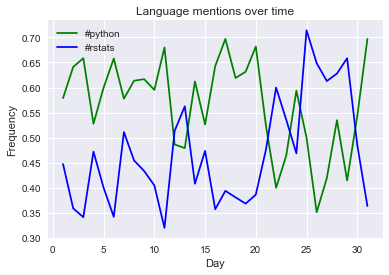

In [14]:
# Average of python column by day
mean_python = ds_tweets['python'].resample('1 d').mean()

# Average of rstats column by day
mean_rstats = ds_tweets['rstats'].resample('1 d').mean()

# Plot mean python/rstats by day
plt.plot(mean_python.index.day, mean_python, color = 'green')
plt.plot(mean_rstats.index.day, mean_rstats, color = 'blue')

# Add labels and show
plt.xlabel('Day'); plt.ylabel('Frequency')
plt.title('Language mentions over time')
plt.legend(('#python', '#rstats'))
plt.show()

### Loading VADER

Sentiment analysis provides us a small glimpse of the meaning of texts with a rather directly interpretable method. While it has its limitations, it's a good place to begin working with textual data. There's a number of out-of-the-box tools in Python we can use for sentiment analysis.

In [24]:
# Instantiate new SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Generate sentiment scores
sentiment_scores = ds_tweets['text'].apply(sid.polarity_scores)

In [25]:
sentiment_scores.head()

created_at
2018-03-01 07:02:41    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2018-03-01 07:57:08    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
2018-03-01 08:09:02    {'neg': 0.0, 'neu': 0.749, 'pos': 0.251, 'comp...
2018-03-01 09:22:21    {'neg': 0.0, 'neu': 0.714, 'pos': 0.286, 'comp...
2018-03-01 12:04:04    {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...
Name: text, dtype: object

In [27]:
sentiment = sentiment_scores.apply(lambda x: x['compound'])

### Calculating sentiment scores

A rough measure of sentiment towards a particular hashtag is to measure average sentiment for tweets mentioning a particular hashtag. It's also possible that other things are happening in that tweet, so it's important to inspect both text as well as metrics generated by automated text methods.

In [28]:
# Print out the text of a positive tweet
print(ds_tweets[sentiment > 0.6]['text'].values[0])

# Print out the text of a negative tweet
print(ds_tweets[sentiment < -0.6]['text'].values[0])

# Generate average sentiment scores for #python
sentiment_py = sentiment[ check_word_in_tweet('#python', ds_tweets) ].resample('1 d').mean()

# Generate average sentiment scores for #rstats
sentiment_r = sentiment[ check_word_in_tweet('#rstats', ds_tweets) ].resample('1 d').mean()

#python goes to #school for #beginner #scientist and #engineer. It's so easy to find solution for #equation in form… https://t.co/JM8jGllwxk
PythonWeekly: one-pixel-attack-keras - Keras reimplementation of "One pixel attack for fooling deep neural networks… https://t.co/LYcIh17Gnr


### Plotting sentiment scores

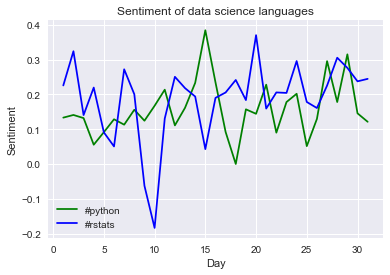

In [29]:
# Import matplotlib
import matplotlib.pyplot as plt

# Plot average #python sentiment per day
plt.plot(sentiment_py.index.day, sentiment_py, color = 'green')

# Plot average #rstats sentiment per day
plt.plot(sentiment_r.index.day, sentiment_r, color = 'blue')

plt.xlabel('Day')
plt.ylabel('Sentiment')
plt.title('Sentiment of data science languages')
plt.legend(('#python', '#rstats'))
plt.show()

In [31]:
sotu_retweets = pd.read_csv("sotu2018-rt.csv")

In [39]:
# Create retweet network from edgelist
G_rt = nx.from_pandas_dataframe(
    sotu_retweets,
    source = 'user-screen_name', 
    target = 'retweeted_status-user-screen_name',
    create_using = nx.DiGraph())
    
# Print the number of nodes
print('Nodes in RT network:', len(G_rt.nodes()))

# Print the number of edges
print('Edges in RT network:', len(G_rt.edges()))

Nodes in RT network: 2287
Edges in RT network: 2340


In [41]:
sotu_replies = pd.read_csv("sotu2018-reply.csv")

In [42]:
# Create reply network from edgelist
G_reply = nx.from_pandas_dataframe(
    sotu_replies,
    source = 'user-screen_name', 
    target = 'in_reply_to_screen_name',
    create_using = nx.DiGraph())
    
# Print the number of nodes
print('Nodes in reply network:', len(G_reply.nodes()))

# Print the number of edges
print('Edges in reply network:', len(G_reply.edges()))

Nodes in reply network: 2622
Edges in reply network: 1904


### In-degree centrality

Centrality is a measure of importance of a node to a network. There are many different types of centrality and each of them has slightly different meaning in Twitter networks. We are first focusing on degree centrality, since its calculation is straightforward and has an intuitive explanation.

For directed networks like Twitter, we need to be careful to distinguish between in-degree and out-degree centrality, especially in retweet networks. In-degree centrality for retweet networks signals users who are getting many retweets.

In [62]:
# column names 
column_names = ['screen_name','degree_centrality']
# Generate in-degree centrality for retweets 
rt_centrality = nx.in_degree_centrality(G_rt)

# Generate in-degree centrality for replies 
reply_centrality = nx.in_degree_centrality(G_reply)

# Store centralities in DataFrame
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)
reply = pd.DataFrame(list(reply_centrality.items()), columns = column_names)

# Print first five results in descending order of centrality
print(rt.sort_values('degree_centrality', ascending = False).head())

# Print first five results in descending order of centrality
print(reply.sort_values('degree_centrality', ascending = False).head())

      screen_name  degree_centrality
84        FoxNews           0.055993
38     WhiteHouse           0.031059
1    ScottPresler           0.029746
7      TomiLahren           0.019685
175      HouseGOP           0.017060
         screen_name  degree_centrality
51   realDonaldTrump           0.057230
53             POTUS           0.019458
22           FoxNews           0.013735
6         WhiteHouse           0.011064
416           FLOTUS           0.010301


### Betweenness Centrality

Betweenness centrality for retweet and reply networks signals users who bridge between different Twitter communities. These communities may be tied together by topic or ideology.

In [63]:
#column names
column_names = ['screen_name', 'betweenness_centrality']
# Generate betweenness centrality for retweets 
rt_centrality = nx.betweenness_centrality(G_rt)

# Generate betweenness centrality for replies 
reply_centrality = nx.betweenness_centrality(G_reply)

# Store centralities in data frames
rt = pd.DataFrame(list(rt_centrality.items()), columns = column_names)
reply = pd.DataFrame(list(reply_centrality.items()), columns = column_names)

# Print first five results in descending order of centrality
print(rt.sort_values('betweenness_centrality', ascending = False).head())

# Print first five results in descending order of centrality
print(reply.sort_values('betweenness_centrality', ascending = False).head())

        screen_name  betweenness_centrality
84          FoxNews                0.000026
29   Public_Citizen                0.000009
206     ChristiChat                0.000005
119      guypbenson                0.000005
362    johncardillo                0.000004
          screen_name  betweenness_centrality
288      ScottPresler            1.019365e-06
319   HRCNJVolunteers            2.912471e-07
1109             RRN3            2.912471e-07
1697    thebestcloser            2.912471e-07
1844   BrandonTXNeely            1.456236e-07


### Ratios

While not strictly a measure of importance to a network, the idea of being "ratio'd" is a network measure which is particular to Twitter and is typically used to judge the unpopularity of a tweet. "The Ratio," as it is called, is calculated by taking the number of replies and dividing it by the number of retweets. For our purposes, it makes conceptual sense to take only the in-degrees of both the retweet and reply networks.

In [ ]:
# adding column names
column_names = ['screen_name', 'degree']
# Calculate in-degrees and store in DataFrame
degree_rt = pd.DataFrame(list(G_rt.in_degree()),columns=column_names)
degree_reply = pd.DataFrame(list(G_reply.in_degree()),columns=column_names)

# Merge the two DataFrames on screen name
ratio = degree_rt.merge(degree_reply, on = 'screen_name', suffixes = ('_rt', '_reply'))

# Calculate the ratio
ratio['ratio'] = ratio['degree_reply'] / ratio['degree_rt']

# Exclude any tweets with less than 5 retweets
ratio = ratio[ratio['degree_rt'] >= 5]

# Print out first five with highest ratio
print(ratio.sort_values('ratio', ascending = False).head())